### Load data 

In [1]:
# import pandas as pd
import modin.pandas as pd
from pandasgui import show
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import ray
ray.init()

2022-04-07 15:41:27,319	INFO services.py:1412 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '127.0.0.1',
 'raylet_ip_address': '127.0.0.1',
 'redis_address': None,
 'object_store_address': 'tcp://127.0.0.1:36447',
 'raylet_socket_name': 'tcp://127.0.0.1:38421',
 'webui_url': '127.0.0.1:8265',
 'session_dir': 'C:\\Users\\obada\\AppData\\Local\\Temp\\ray\\session_2022-04-07_15-41-24_319610_23600',
 'metrics_export_port': 62877,
 'gcs_address': '127.0.0.1:62737',
 'address': '127.0.0.1:62737',
 'node_id': '3b64981710a4a9b66897e3dbfa8e9de3d87cbc1e6b340c1ce59bbdef'}

In [3]:
all_data = pd.read_csv("lyrics-dataset-v5.csv")
all_data.dropna(subset=["lyrics"], inplace=True)

Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.


In [4]:
all_data["lyrics"] = all_data["lyrics_no_stopwords_lemmatized"].astype(str)
all_data["genre"] = all_data["genre"].astype(str)

In [91]:
all_data[all_data["number_of_words"]< 60][["lyrics_no_stopwords_lemmatized", "genre"]].sample(5).to_clipboard()

### Add nouns/verbs column

In [5]:
from nltk import word_tokenize, pos_tag

def get_only_pos(text, allowed_pos=["NN"]):
    pos_split = pos_tag(word_tokenize(text))
    relevant = ""
    for word, pos in pos_split:
        if pos[:2] in allowed_pos:
            relevant += " " + word
            
    return relevant.strip()

# NN - nouns, VB - verbs, JJ - adjective, RB - adverbs, UH - interjection

In [6]:
from tqdm.notebook import tqdm
# from modin.config import ProgressBar
# ProgressBar.enable()
tqdm.pandas()

In [7]:
all_data["verbs"] = all_data["lyrics"].apply(lambda x: get_only_pos(x, ["VB"]))

In [33]:
all_data["nouns"] = all_data["lyrics"].apply(lambda x: get_only_pos(x, ["NN"]))

In [41]:
all_data["adj_adv"] = all_data["lyrics"].apply(lambda x: get_only_pos(x, ["JJ", "RB"]))

In [10]:
all_data["interjections"] = all_data["lyrics"].apply(lambda x: get_only_pos(x, ["UH"]))

### Word Cloud of all text 

In [11]:
from wordcloud import WordCloud
text = " ".join(all_data.lyrics.tolist())
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white", collocations=False).generate(text)

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.


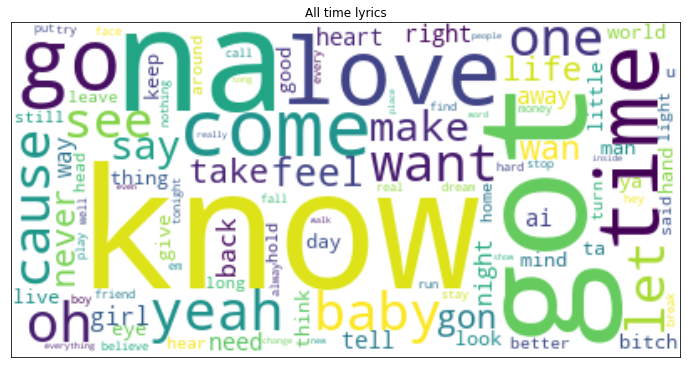

In [12]:
plt.figure(figsize=(12, 8), facecolor="white")
plt.imshow(wordcloud, interpolation="bilinear")
plt.xticks([]); plt.yticks([])
plt.title("All time lyrics")
plt.show()

In [13]:
all_data.shape

(56525, 15)

In [14]:
# Just verbs
all_verbs_text = " ".join(all_data.verbs.tolist())
wordcloud_verbs = WordCloud(max_font_size=100, max_words=100, background_color="white", collocations=False).generate(all_verbs_text)

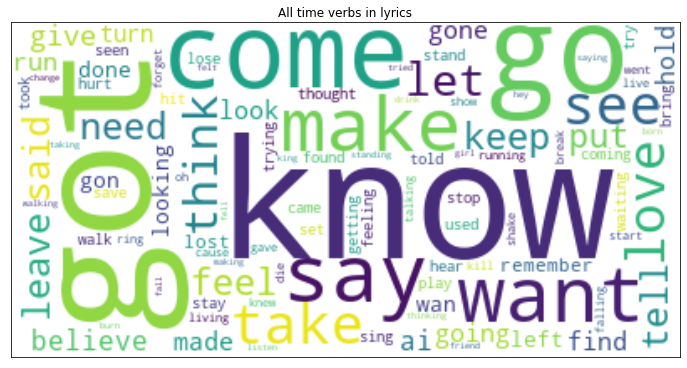

In [15]:
plt.figure(figsize=(12, 8), facecolor="white")
plt.imshow(wordcloud_verbs, interpolation="bilinear")
plt.xticks([]); plt.yticks([])
plt.title("All time verbs in lyrics")
# plt.show()
plt.savefig("all-time-verbs.png")

In [16]:
# Just nouns
all_nouns_text = " ".join(all_data.nouns.tolist())
wordcloud_nouns = WordCloud(max_font_size=100, max_words=100, background_color="white", collocations=False).generate(all_nouns_text)

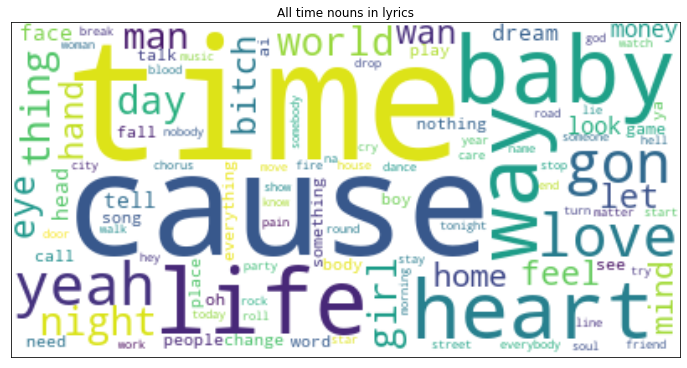

In [17]:
plt.figure(figsize=(12, 8), facecolor="white")
plt.imshow(wordcloud_nouns, interpolation="bilinear")
plt.xticks([]); plt.yticks([])
plt.title("All time nouns in lyrics")
# plt.show()
plt.savefig("all-time-nouns.png")

In [19]:
# Just adjectives/adverbs
all_adjadv_text = " ".join(all_data.adj_adv.tolist()).replace("n't", "")
wordcloud_adjadv = WordCloud(max_font_size=100, max_words=100, background_color="white", collocations=False).generate(all_adjadv_text)

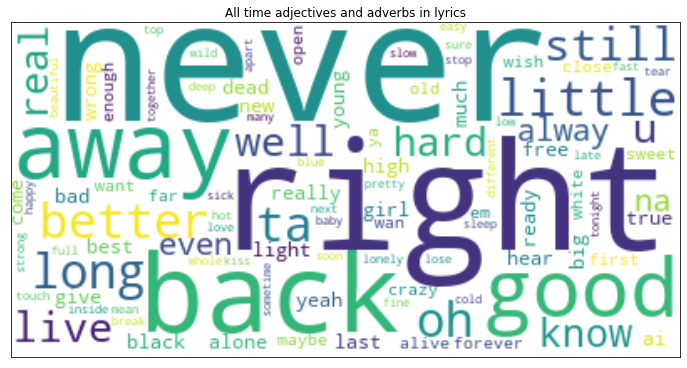

In [20]:
plt.figure(figsize=(12, 8), facecolor="white")
plt.imshow(wordcloud_adjadv, interpolation="bilinear")
plt.xticks([]); plt.yticks([])
plt.title("All time adjectives and adverbs in lyrics")
# plt.show()
plt.savefig("all-time-adjadv.png")

### Word clouds of separate genres 

In [72]:
def plot_nouns_by_genre(genre):

    text = " ".join(all_data[all_data.genre==genre]["nouns"].tolist())

    # print(text[:50])
    wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white", collocations=False).generate(text)
    plt.figure(figsize=(12, 8), facecolor="white")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.xticks([]); plt.yticks([])
    plt.title("Lyrics " + genre)
    plt.show()

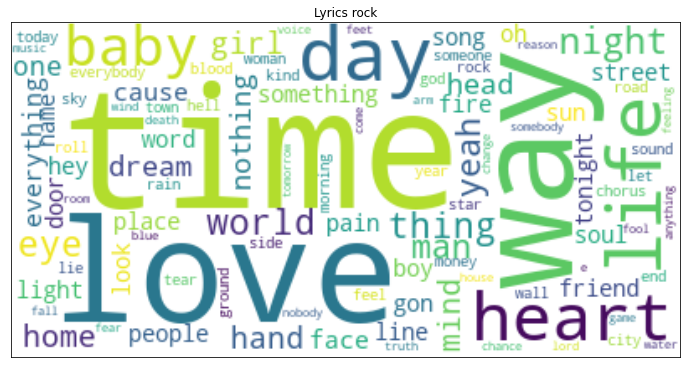

In [73]:
plot_nouns_by_genre("rock")

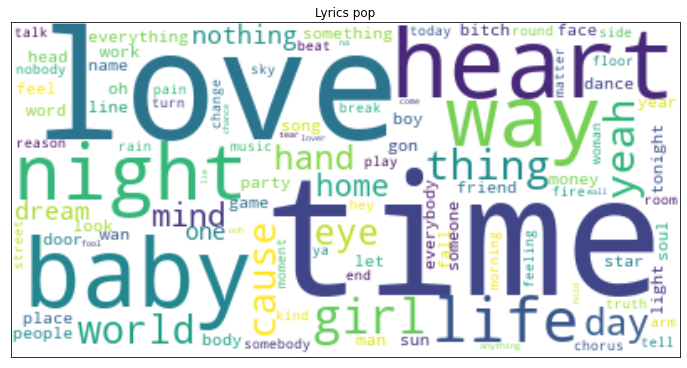

In [74]:
plot_nouns_by_genre("pop")

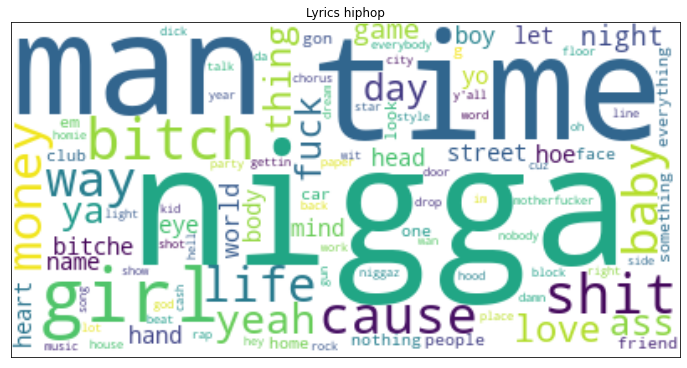

In [75]:
plot_nouns_by_genre("hiphop")

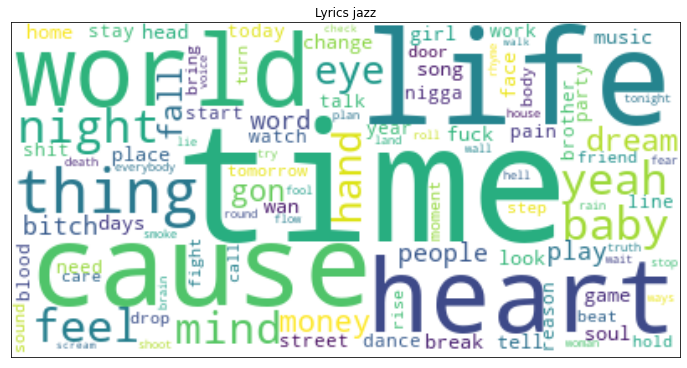

In [76]:
plot_nouns_by_genre("jazz")

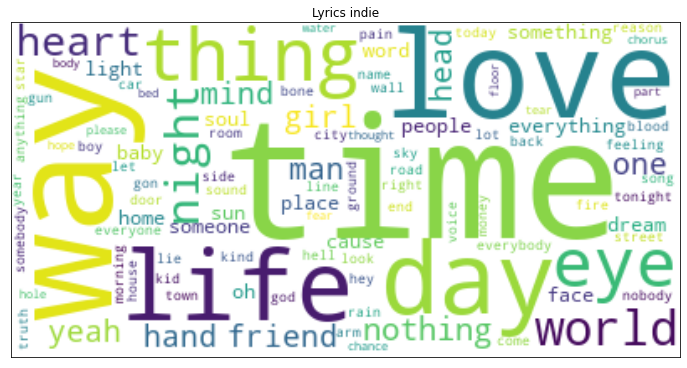

In [83]:
plot_nouns_by_genre("indie")

In [77]:
pd.unique(all_data.genre)

array(['hiphop', 'pop', 'indie', 'rock', 'heavy', 'dance', 'country',
       'blues', 'jazz', 'reggae'], dtype=object)

In [103]:
def plot_adjadv_by_genre(genre):

    text = " ".join(all_data[all_data.genre==genre]["adj_adv"].tolist()).replace("n't", "")

    # print(text[:50])
    wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white", collocations=False).generate(text)
    plt.figure(figsize=(12, 8), facecolor="white")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.xticks([]); plt.yticks([])
    plt.title("Lyrics " + genre)
    plt.show()

Estimated completion of line 17:   0%           Elapsed time: 00:00, estimated remaining time: ?

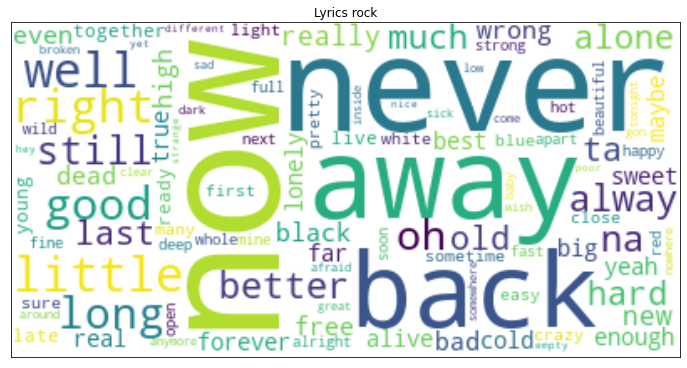

In [104]:
plot_adjadv_by_genre("rock")

Estimated completion of line 17:   0%           Elapsed time: 00:00, estimated remaining time: ?

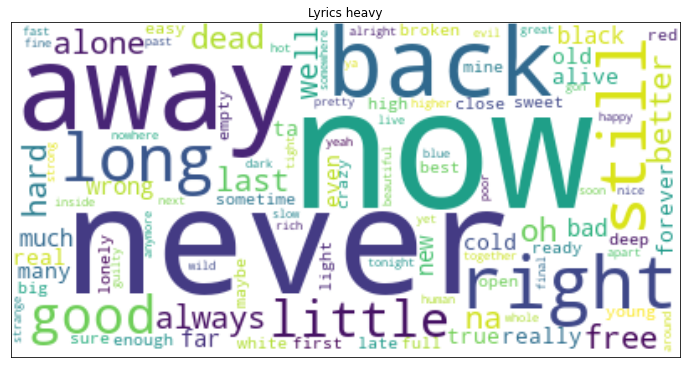

In [105]:
plot_adjadv_by_genre("heavy")

Estimated completion of line 17:   0%           Elapsed time: 00:00, estimated remaining time: ?

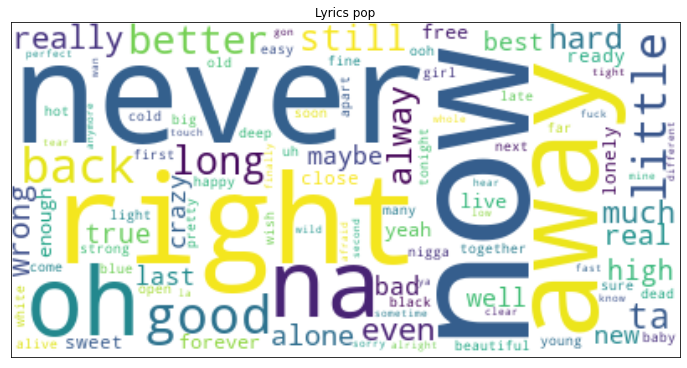

In [106]:
plot_adjadv_by_genre("pop")

Estimated completion of line 17:   0%           Elapsed time: 00:00, estimated remaining time: ?

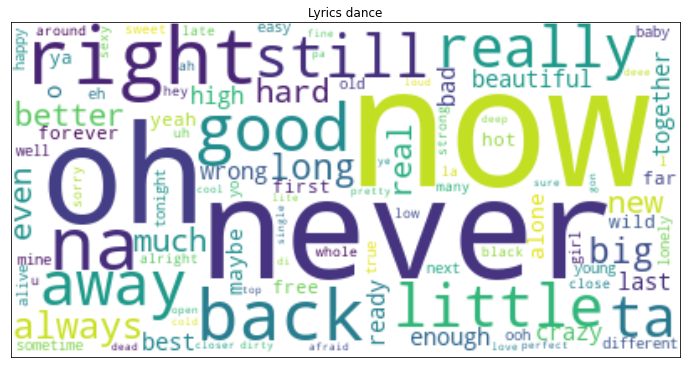

In [109]:
plot_adjadv_by_genre("dance")

### Word clouds of separate time splits 

In [42]:
history_data = all_data[all_data.year.notna()]

In [22]:
split_values_year = [1980, 2000]
years_1950_1980 = history_data[history_data.year <= split_values_year[0]]
years_1980_2000 = history_data[(history_data.year >= split_values_year[0]) & (history_data.year <= split_values_year[1])]
years_2000_2019 = history_data[history_data.year >= split_values_year[1]]

In [31]:
def plot_by_year_splits(field = "lyrics", genre = None):
    for label, years in zip(["1950-1980", "1980-2000", "2000-2019"], [years_1950_1980, years_1980_2000, years_2000_2019]):
        
        if genre:
            text = " ".join(years.loc[years.genre == genre, field].tolist())
        else:
            text = " ".join(years[field].tolist())
        
        # print(text[:50])
        wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white", collocations=False).generate(text)
        plt.figure(figsize=(12, 8), facecolor="white")
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.xticks([]); plt.yticks([])
        plt.title("Lyrics from " + label)
        # plt.show()
        plt.savefig("")

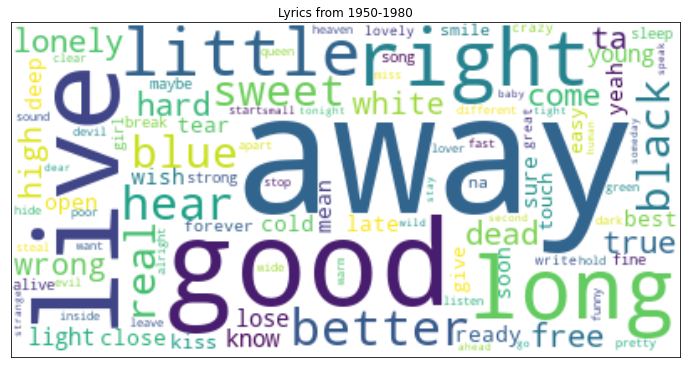

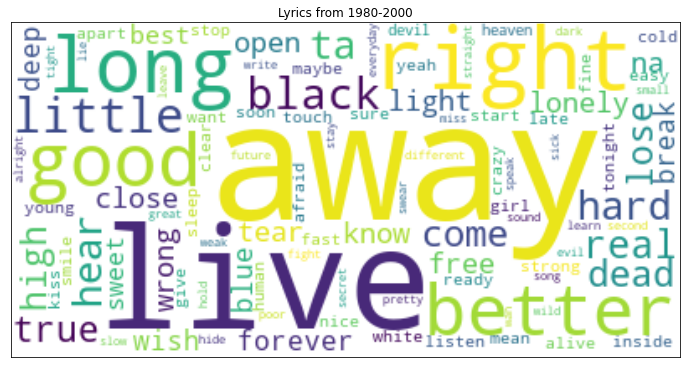

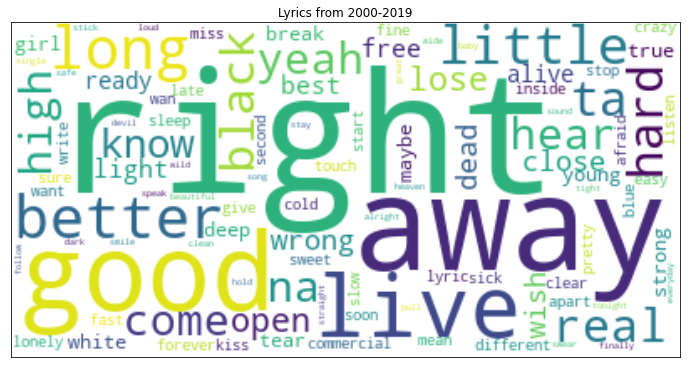

In [59]:
plot_by_year_splits("adj_adv")

### Most popular word by genre

In [45]:
genre_lyrics = all_data.groupby("genre")["lyrics"].agg(lambda l: " ".join(l))

In [47]:
most_popular_words_dict = {k: list(WordCloud(max_words=4, collocations=False).generate(genre_lyrics[k]).words_)[:3] for k in genre_lyrics.index}

In [48]:
most_popular_words_dict

{'blues': ['know', 'time', 'come'],
 'country': ['know', 'time', 'heart'],
 'dance': ['love', 'na', 'know'],
 'heavy': ['know', 'love', 'time'],
 'hiphop': ['got', 'know', 'ai'],
 'indie': ['know', 'oh', 'got'],
 'jazz': ['know', 'come', 'time'],
 'pop': ['know', 'na', 'love'],
 'reggae': ['know', 'come', 'time'],
 'rock': ['know', 'love', 'got']}

### Plot complexity

In [60]:
yearly_words = history_data.groupby("year")["number_of_words"].mean()

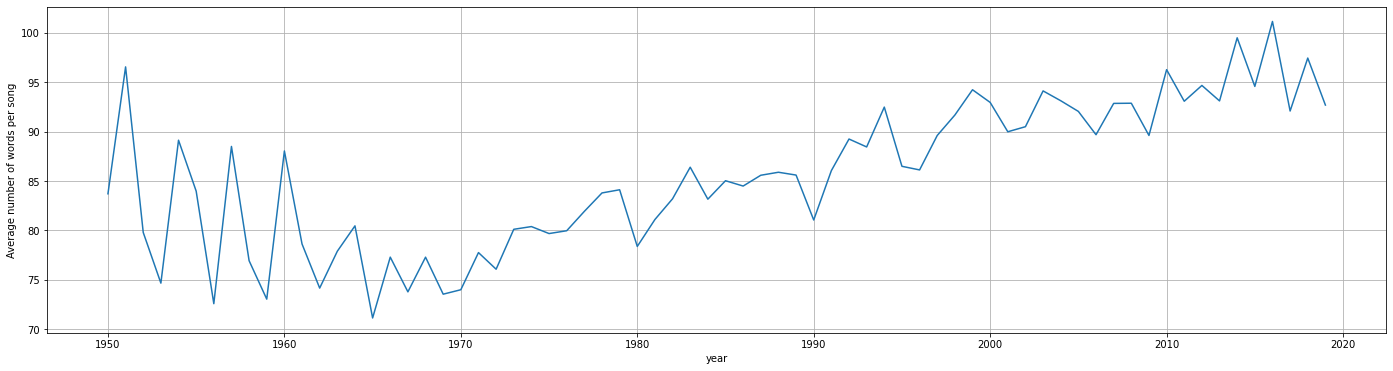

In [62]:
plt.figure(figsize=(24, 6))
plt.plot(yearly_words.index, yearly_words.values)
plt.xlabel("year")
plt.ylabel("Average number of words per song")
plt.grid()
plt.savefig("yearly-complexity.png")

In [81]:
# Plot by genre
yearly_words_with_genre = history_data.groupby(["year", "genre"], as_index=False)["number_of_words"].mean()

# Remove outliers
yearly_words_with_genre.drop(index=yearly_words_with_genre[(yearly_words_with_genre.genre == "hiphop") & (yearly_words_with_genre.year <= 2000)].index, 
                             inplace=True)

yearly_words_with_genre.drop(index=yearly_words_with_genre[(yearly_words_with_genre.genre == "reggae") & (yearly_words_with_genre.year <= 1974)].index, 
                             inplace=True)

yearly_words_with_genre.drop(index=yearly_words_with_genre[(yearly_words_with_genre.genre == "pop") & (yearly_words_with_genre.year <= 1951)].index, 
                             inplace=True)

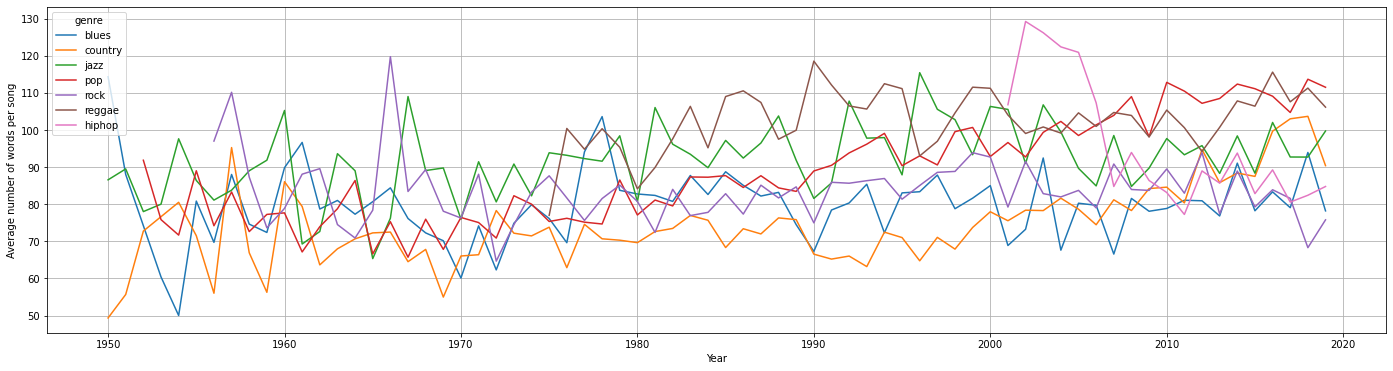

In [92]:
plt.figure(figsize=(24, 6))
sns.lineplot(x="year", y="number_of_words", hue="genre", data=yearly_words_with_genre)
plt.xlabel("Year")
plt.ylabel("Average number of words per song")
plt.grid()
plt.savefig("yearly-complexity-by-genre.png")

### Dynamics: how many verbs

In [48]:
history_data["verbs_dynamics"] = history_data.verbs.apply(lambda toklist: len(toklist.split(" "))) / history_data.nouns.apply(lambda toklist: len(toklist.split(" ")))

In [49]:
yearly_verbs_dynamics = history_data.groupby("year")["verbs_dynamics"].mean()

In [50]:
yearly_verbs_dynamics

year
1950.0    0.446899
1951.0    0.327602
1952.0    0.321773
1953.0    0.345922
1954.0    0.322640
            ...   
2015.0    0.350689
2016.0    0.335696
2017.0    0.321340
2018.0    0.329766
2019.0    0.309447
Name: verbs_dynamics, Length: 70, dtype: float64

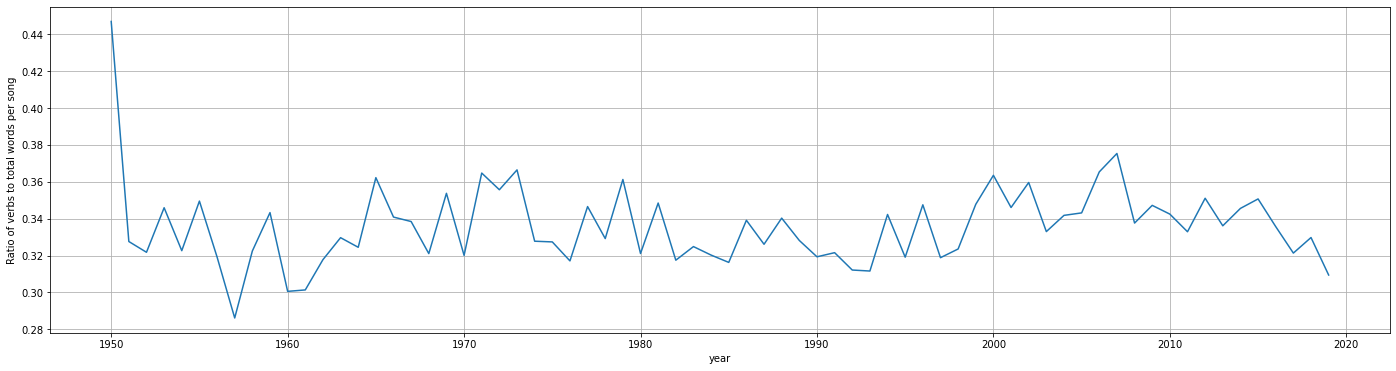

In [51]:
plt.figure(figsize=(24, 6))
plt.plot(yearly_verbs_dynamics.index, yearly_verbs_dynamics.values)
plt.xlabel("year")
plt.ylabel("Ratio of verbs to total words per song")
plt.grid()
# plt.savefig("yearly-complexity.png")

### Plot extra features

<AxesSubplot:xlabel='genre'>

<Figure size 864x576 with 0 Axes>

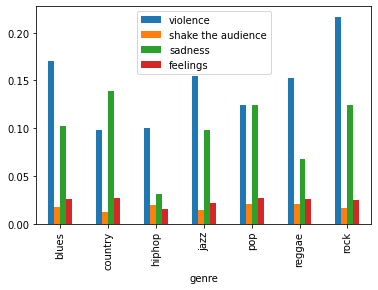

In [39]:
plt.figure(figsize=(12, 8))
all_data[pd.notna(all_data.danceability)].groupby("genre")["violence", "shake the audience", "sadness", "feelings"].mean().plot(kind='bar')

<AxesSubplot:xlabel='genre'>

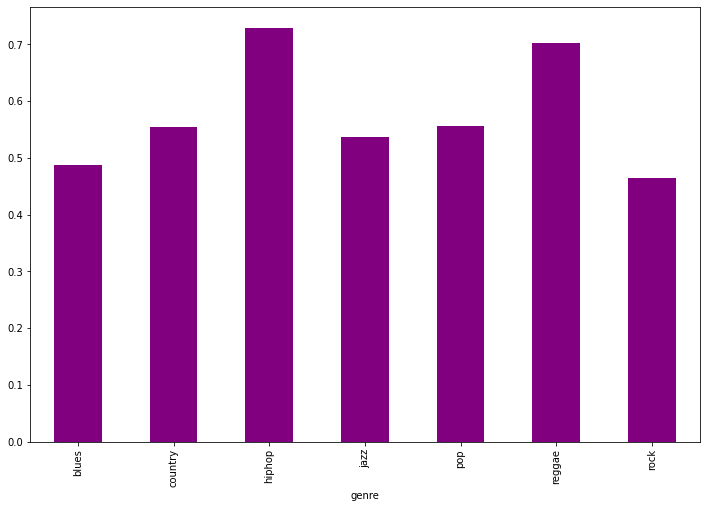

In [37]:
plt.figure(figsize=(12, 8))
all_data[pd.notna(all_data.danceability)].groupby("genre")["danceability"].mean().plot(kind='bar', color='purple')